# Network analysis for coauthors - modularity

This looks at modularity of the main subgraph.

In [3]:
import sklearn
sklearn.__version__

'0.24.1'

In [4]:
%load_ext autoreload
%autoreload 2

from src.util import load_coauthor_nx, ddir_analysis, fn_nodes, fn_statoids, get_spp_df

import community
import networkx as nx
from operator import itemgetter
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import skbio.diversity.alpha as b
import math
import random

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn import preprocessing
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Params
seed = 2021
random.seed(seed)

# Load graph
(G, nodes) = load_coauthor_nx() # abstracted into src


Name: 
Type: Graph
Number of nodes: 391
Number of edges: 510
Average degree:   2.6087


## Communities

In [6]:
# Read data
nodes_df = pd.read_csv(fn_nodes)
statoids = pd.read_csv(fn_statoids)
statoids = area_dict = dict(zip(statoids.DL, statoids.Country))

spp = get_spp_df()

spp.head(3)

/home/ejysoh/miniconda3/envs/msc/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (22,30,60,61,65,86,89,106,117) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/mnt/c/_dev/msc/thesis/2021-06-02-jsa-type-v2-china/src/util.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spp = spp[~spp['duplicated']][


,idx,date,status,duplicated,full_name_of_describer
1,2,2004,Valid species,False,Carlos Hernan Vergara
1,2,2004,Valid species,False,Charles Duncan Michener
2,3,2004,Valid species,False,Charles Duncan Michener


In [7]:
# Add module information
communities = community.best_partition(G, random_state=seed)  # https://python-louvain.readthedocs.io/en/latest/api.html
nx.set_node_attributes(G, communities, 'modularity')

In [14]:
G.nodes["Yan-ru Wu"]

{'country_of_residence': 'CH',
 'ns_spp_n': 195,
 'degree': 7,
 'betweenness': 0.007964309214876283,
 'eigenvector': 0.0038379240915783607,
 'modularity': 12}

                                 0                          1               2
0                     Kamel Louadi             Erwin Scheuchl   {'weight': 1}
1                     Kamel Louadi           Noudjoud Benarfa   {'weight': 1}
2                 Noudjoud Benarfa             Erwin Scheuchl   {'weight': 1}
3          Alberto H. Abrahamovich              Mariano Lucia   {'weight': 3}
4          Alberto H. Abrahamovich        Leopoldo J. Alvarez   {'weight': 1}
..                             ...                        ...             ...
417              Terry L. Griswold             Wensdae Miller   {'weight': 2}
418              Terry L. Griswold            Zach M. Portman   {'weight': 5}
419              Terry L. Griswold       Victor Hugo Gonzalez  {'weight': 45}
420  Theodore Dru Alison Cockerell  Wilmatte Porter Cockerell  {'weight': 10}
421            Thomas J. Zavortink     Wallace Edmund LaBerge   {'weight': 1}

[422 rows x 3 columns]


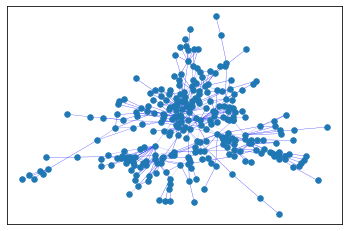

In [35]:
# Plotting one of the subgraphs
subgraphs = [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]

wu_subgraph = ["Yan-ru Wu" in subgraph for subgraph in subgraphs].index(True)
S = G.subgraph(subgraphs[wu_subgraph])
print(pd.DataFrame(S.edges(data=True)))
pos=nx.spring_layout(S) 
nx.draw_networkx_nodes(S, pos, node_size=30)
# nx.draw_networkx_labels(S, pos, font_size=10,font_color='g')

all_weights = []
for (n1, n2, attr) in S.edges(data=True):
    all_weights.append(attr['weight'])
unique_weights = list(set(all_weights))

for wt in range(1, int(max(unique_weights))+1):
    edges = [(n1,n2) for (n1, n2, attr) in S.edges(data=True) if attr['weight']==wt]
    width = wt*len(edges)*3.0/sum(all_weights)
    nx.draw_networkx_edges(S, pos, edgelist=edges, width=width, edge_color='b')